In [ ]:
# importing required libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Keras tuner installation
! pip install keras-tuner

# deeplearning libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# importing the metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.3 MB/s eta 0:00:00


In [ ]:
# Data source - https://keras.io/api/datasets/fashion_mnist/

# Data loading
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# data dimension
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
# Classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

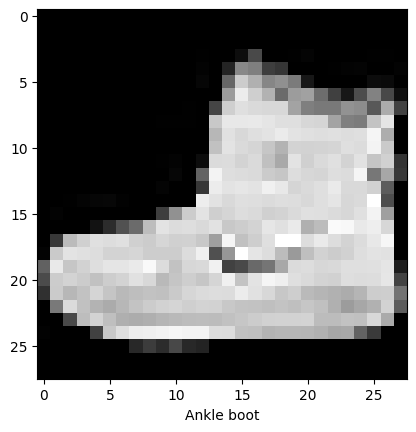

In [ ]:
# display first image from the data
plt.imshow(x_train[0], cmap='grey')
plt.xlabel(classes[y_train[0]])
plt.show()

In [ ]:
# Scaling the data
x_train = x_train/255
x_test = x_test/255

In [ ]:
# re-shape the data into 4 dimension
x_train = x_train.reshape(len(x_train), 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)

In [ ]:
# Building a hyper model

def hyper_model(hp):
    model = Sequential([
        Conv2D(filters = hp.Int('conv_1_filter', min_value=32, max_value=128, step=8),
               kernel_size = hp.Choice('conv_1_kernal', values=[3,5]),
               activation='relu',
               input_shape=(28,28,1)
               ),
        Conv2D(filters = hp.Int('conv_2_filter', min_value=8, max_value=68, step=4),
               kernel_size = hp.Choice('conv_2_kernal', values=[3,5]),
               activation='relu'
               ),
        MaxPooling2D((2,2)),

        Flatten(),

        Dense(units = hp.Int('dense_1_units', min_value=32, max_value=256, step=4),
              activation='relu'),
        Dense(units = hp.Int('dense_2_units', min_value=32, max_value=128, step=4),
              activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner_output = RandomSearch(hyper_model,
                            objective = 'val_accuracy',
                            max_trials = 5,
                            project_name = 'Mnist Optmising')

In [ ]:
# tuner search
tuner_output.search(x_train, y_train, epochs=10, validation_split=0.2)

Trial 5 Complete [00h 01m 38s]
val_accuracy: 0.10125000029802322

Best val_accuracy So Far: 0.9099166393280029
Total elapsed time: 00h 06m 39s


In [ ]:
# Extracting the best model out of all
model = tuner_output.get_best_models(num_models=1)[0]

In [ ]:
# best model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 24, 24, 48)          │           1,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 56)          │          24,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 11, 56)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6776)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 192)                 │       1,301,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 124)                 │          23,932 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,351,862 (5.16 MB)

 Trainable params: 1,351,862 (5.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fitting the data in the best model
model.fit(x_train, y_train, epochs=15, validation_split=0.1, initial_epoch=10)

Epoch 11/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9370 - loss: 0.1721 - val_accuracy: 0.9058 - val_loss: 0.2534
Epoch 12/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9436 - loss: 0.1559 - val_accuracy: 0.9137 - val_loss: 0.2443
Epoch 13/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9493 - loss: 0.1405 - val_accuracy: 0.9200 - val_loss: 0.2293
Epoch 14/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9542 - loss: 0.1292 - val_accuracy: 0.9192 - val_loss: 0.2325
Epoch 15/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9565 - loss: 0.1202 - val_accuracy: 0.9218 - val_loss: 0.2249


In [ ]:
# model evaluation
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9199 - loss: 0.2513


[0.24477235972881317, 0.9204000234603882]

In [ ]:
# predictions
y_pred = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [ ]:
# prediction for first image
y_pred[0]

array([3.7934100e-08, 6.0565525e-10, 3.1590939e-09, 1.3634271e-08,
       4.3097199e-11, 1.5113966e-05, 1.2961681e-09, 2.4196279e-04,
       1.0857657e-07, 9.9974281e-01], dtype=float32)

In [ ]:
# index number of the predicted class based on highest probability
y_class = [np.argmax(ele) for ele in y_pred]
y_class[:5]

[9, 2, 1, 1, 6]

In [ ]:
# Funtion for random image prediction

def validate_rdm_img():
    '''This function validates a random image from the test data and returns the prediction'''

    rdm_img = random.randint(0, len(x_test))
    plt.imshow(x_test[rdm_img, :], cmap='grey')
    plt.show()

    print('Actual Image is:', classes[y_test[rdm_img]])
    print('Predicted Image is:', classes[y_class[rdm_img]])
    print('Predicted Image Probability:', round(y_pred[rdm_img][y_class[rdm_img]]*100 ,2), '%')

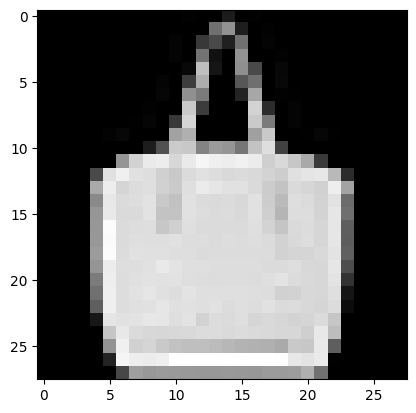

Actual Image is: Bag
Predicted Image is: Bag
Predicted Image Probability: 100.0 %


In [ ]:
validate_rdm_img()

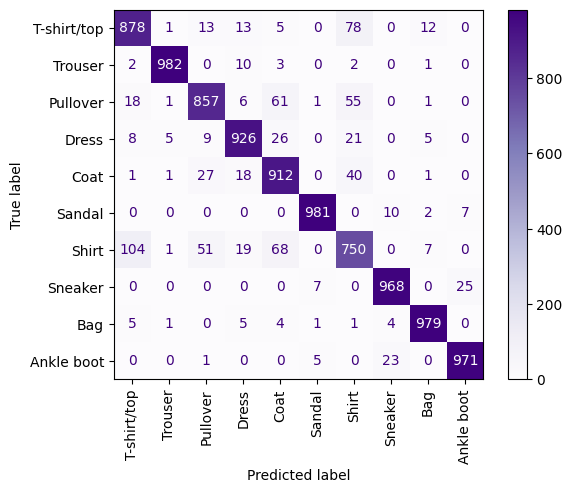

In [ ]:
# Confusion Matrix
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_class, display_labels=classes,
                                             xticks_rotation='vertical', cmap='Purples')